<a href="https://colab.research.google.com/github/dbos23/Clustering-Bank-Loan-Applicants/blob/main/Thinkful_Unsupervised_Learning_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'll be working with a dataset I found at:
https://www.kaggle.com/datasets/atulmittal199174/credit-risk-analysis-for-extending-bank-loans

My goal will be to cluster potential bank loan recipients, with individuals in the same cluster presenting similar levels of risk to the bank providing the loans.

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
raw_df = pd.read_csv('/content/bankloans.csv')

# Data Cleaning - Missing Values

I'll start by cleaning the data.

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


The dataframe has 9 variables:
- age (continuous)
- ed (categorical: education level represented by integers from 1-5)
- employ (continuous: years of work experience)
- address
- income (continuous: annual income in thousands of dollars)
- debtinc (continuous: debt to income ratio)
- creddebt (continuous: credit to debt ratio)
- othdebt (continuous: amount of money owed in other debts)
- default (boolean: whether or not the individual has defaulted on a loan before)

Address is not a useful predictor so I'll remove that now.

In [ ]:
raw_df.drop('address', axis=1, inplace=True)

At this point in my education, the clustering algorithms with which I'm familiar use Euclidean distance and other similar metrics to group observations, making them incompatible with categorical variables. So I'll have to drop the ed and default variables as well.

In [ ]:
raw_df.drop(['ed', 'default'], axis=1, inplace=True)

The data types given by the info method are all either int64 or float64, indicating that there are no missing values masquerading as strings. Moreover, values of 0 are reasonable for all of these variables except for age. I'll check age for values of 0 but otherwise it's safe to conclude that there are no missing values disguised as 0.

In [ ]:
raw_df['age'].unique()

array([41, 27, 40, 24, 39, 43, 36, 25, 52, 37, 48, 47, 28, 29, 21, 45, 33,
       26, 30, 32, 23, 34, 42, 35, 46, 38, 50, 31, 53, 54, 22, 55, 44, 51,
       49, 20, 56])

There are no anomalous values for age so it seems that there are no missing values in the dataframe. Next I'll look for outliers.

# Data Cleaning - Outliers

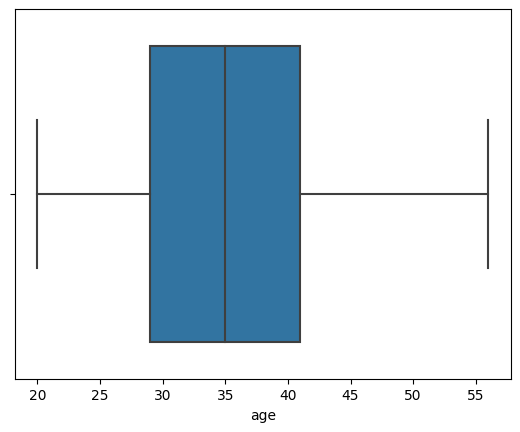

In [ ]:
sns.boxplot(data=raw_df, x='age', whis=3)
plt.show()

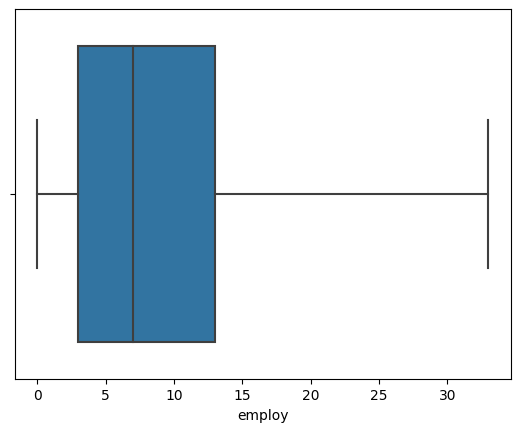

In [ ]:
sns.boxplot(data=raw_df, x='employ', whis=3)
plt.show()

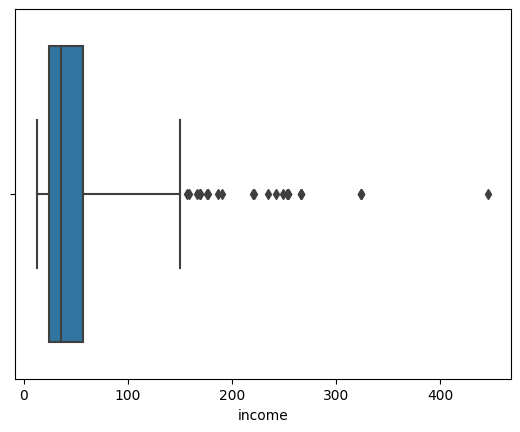

In [ ]:
sns.boxplot(data=raw_df, x='income', whis=3)
plt.show()

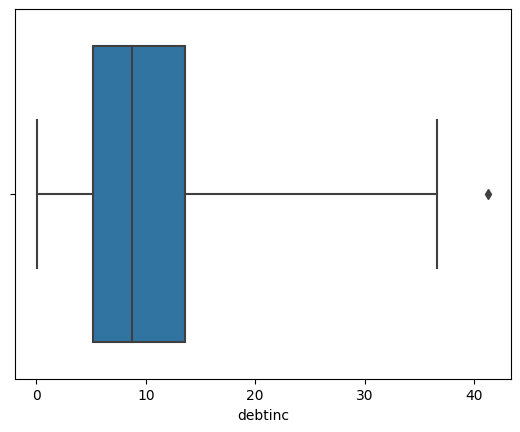

In [ ]:
sns.boxplot(data=raw_df, x='debtinc', whis=3)
plt.show()

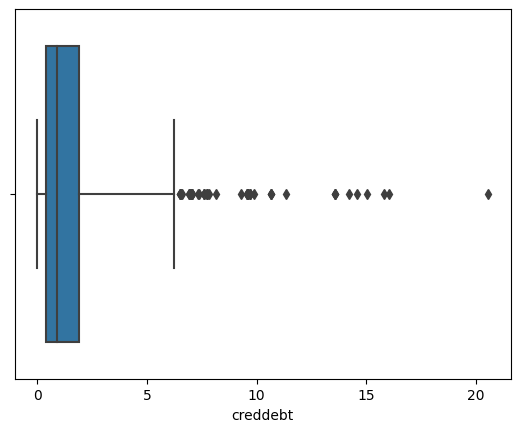

In [ ]:
sns.boxplot(data=raw_df, x='creddebt', whis=3)
plt.show()

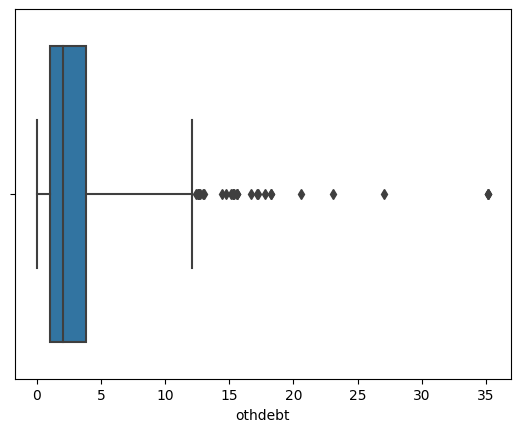

In [ ]:
sns.boxplot(data=raw_df, x='othdebt', whis=3)
plt.show()

There are outliers for income, debtinc, creddebt, and othdebt that need to be addressed,

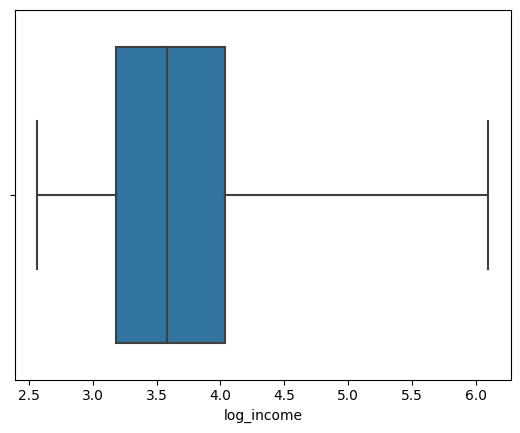

In [ ]:
raw_df['log_income'] = np.log(raw_df['income'])
sns.boxplot(data=raw_df, x='log_income', whis=3)
plt.show()

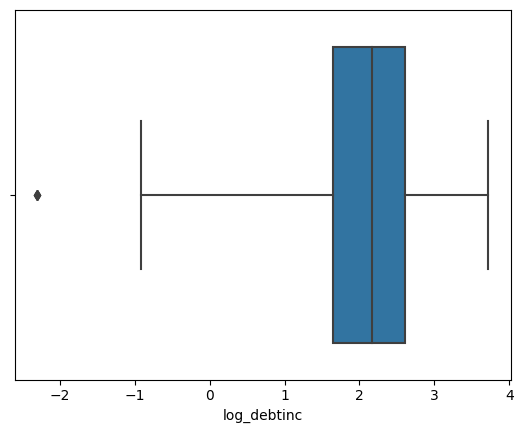

In [ ]:
raw_df['log_debtinc'] = np.log(raw_df['debtinc'])
sns.boxplot(data=raw_df, x='log_debtinc', whis=3)
plt.show()

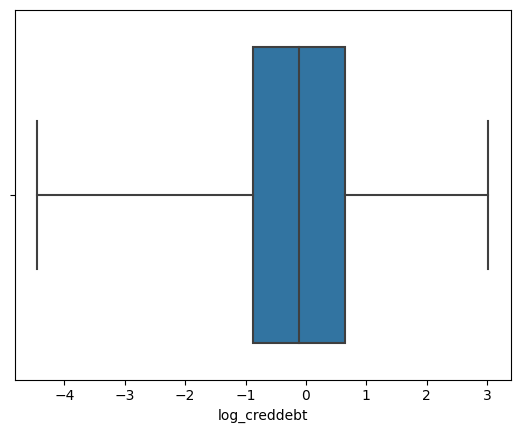

In [ ]:
raw_df['log_creddebt'] = np.log(raw_df['creddebt'])
sns.boxplot(data=raw_df, x='log_creddebt', whis=3)
plt.show()

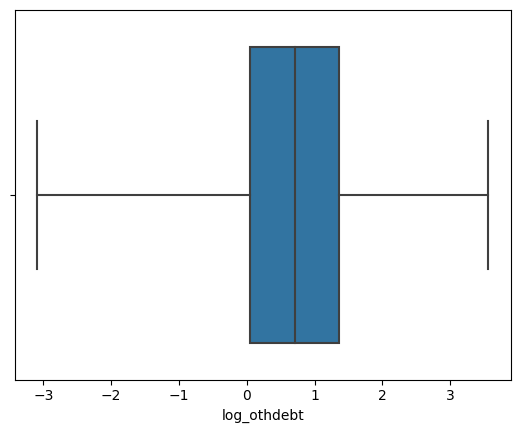

In [ ]:
raw_df['log_othdebt'] = np.log(raw_df['othdebt'])
sns.boxplot(data=raw_df, x='log_othdebt', whis=3)
plt.show()

Taking the log transformations of these variables, only one outlier remains in log_debtinc. There was only one outlier for the original debtinc variable so I'll try winsorizing that instead.

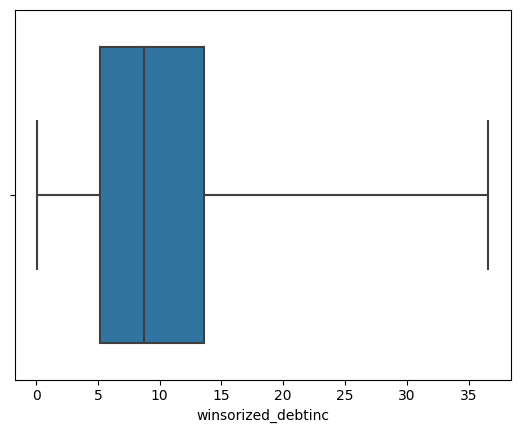

In [ ]:
raw_df['winsorized_debtinc'] = stats.mstats.winsorize(raw_df['debtinc'], (0, .001))
sns.boxplot(data=raw_df, x='winsorized_debtinc', whis=3)
plt.show()

Now that the outliers have been dealt with, I'll create a new dataframe containing the newly cleaned variables.

In [ ]:
df = raw_df[['age', 'employ', 'log_income', 'winsorized_debtinc','log_creddebt', 'log_othdebt']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 1150 non-null   int64  
 1   employ              1150 non-null   int64  
 2   log_income          1150 non-null   float64
 3   winsorized_debtinc  1150 non-null   float64
 4   log_creddebt        1150 non-null   float64
 5   log_othdebt         1150 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 54.0 KB


# Data Exploration

Next I'll examine each variable in relation to the other variables and individually.

In [ ]:
df.corr()

,age,employ,log_income,winsorized_debtinc,log_creddebt,log_othdebt
age,1.000000,0.574267,0.560737,-0.000989,0.266763,0.308378
employ,0.574267,1.000000,0.714996,-0.036314,0.319126,0.382403
log_income,0.560737,0.714996,1.000000,-0.025248,0.502184,0.555208
winsorized_debtinc,-0.000989,-0.036314,-0.025248,1.000000,0.581267,0.653320
log_creddebt,0.266763,0.319126,0.502184,0.581267,1.000000,0.630698
log_othdebt,0.308378,0.382403,0.555208,0.653320,0.630698,1.000000


There are some fairly strong correlations here, most notably between log_income and employ with a correlation coefficient of 0.71.

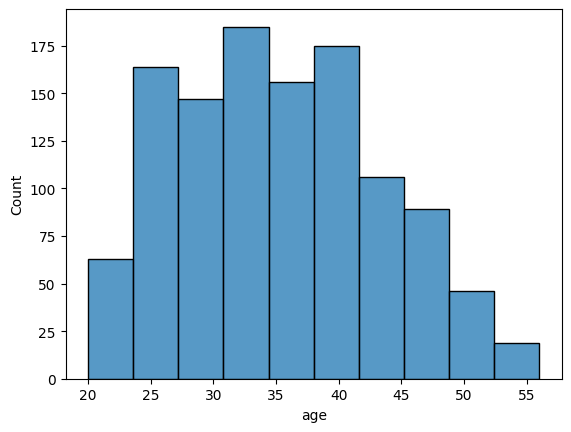

In [ ]:
sns.histplot(data=df, x='age', bins=10)
plt.show()

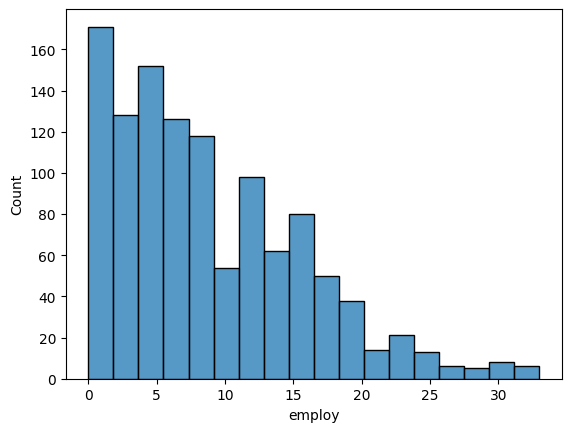

In [ ]:
sns.histplot(data=df, x='employ')
plt.show()

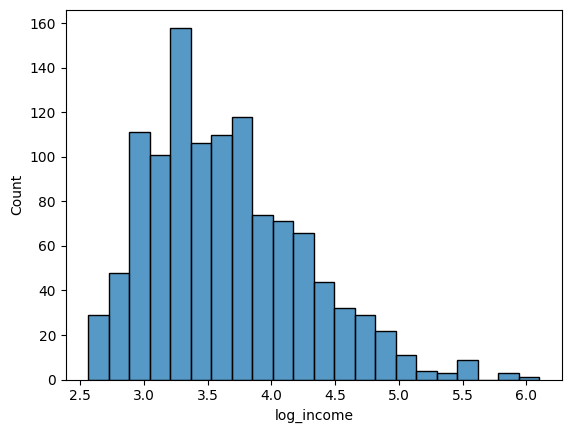

In [ ]:
sns.histplot(data=df, x='log_income')
plt.show()

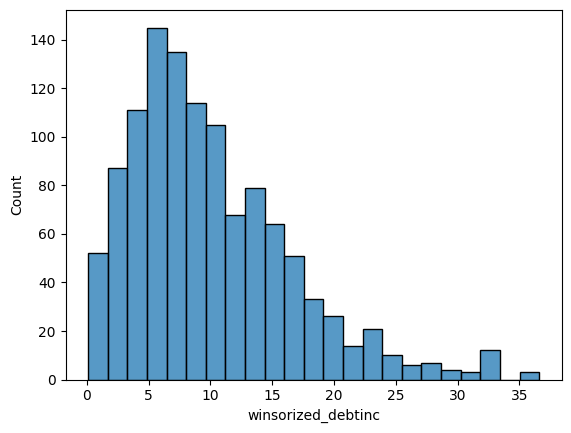

In [ ]:
sns.histplot(data=df, x='winsorized_debtinc')
plt.show()

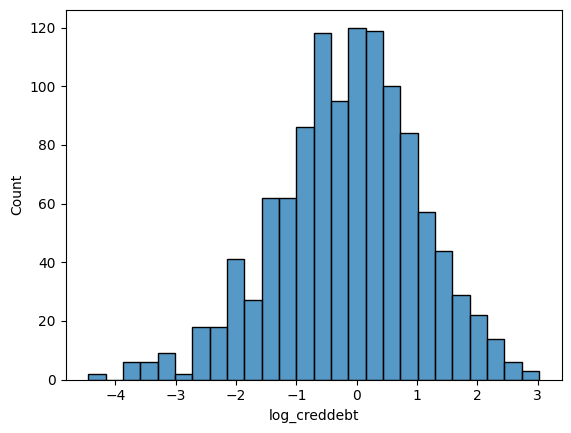

In [ ]:
sns.histplot(data=df, x='log_creddebt')
plt.show()

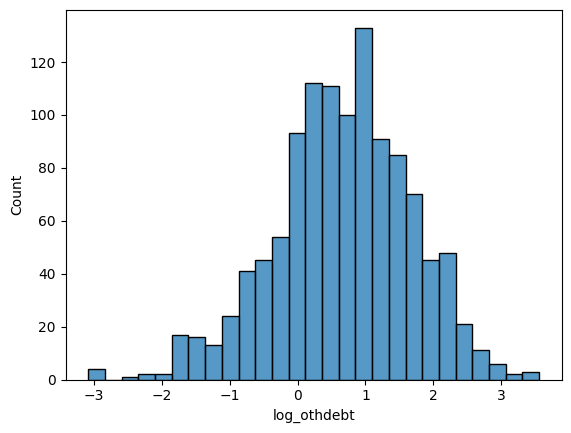

In [ ]:
sns.histplot(data=df, x='log_othdebt')
plt.show()

For each variable, I'll perform a Jarque-Bera test and a normal test to see if its distribution can be considered normal.

In [ ]:
vars = df.columns.tolist()

for var in vars:
  print(f'{var}: ')
  print(f'Jarque-Bera test: {stats.jarque_bera(df[var])}')
  print(f'Normal test: {stats.normaltest(df[var])}')
  print('-'*50)

age: 
Jarque-Bera test: SignificanceResult(statistic=41.78975046815278, pvalue=8.423081168890339e-10)
Normal test: NormaltestResult(statistic=78.89437129369104, pvalue=7.384225435829665e-18)
--------------------------------------------------
employ: 
Jarque-Bera test: SignificanceResult(statistic=163.64006658114533, pvalue=2.924226663596446e-36)
Normal test: NormaltestResult(statistic=124.23200550982051, pvalue=1.0552679924281252e-27)
--------------------------------------------------
log_income: 
Jarque-Bera test: SignificanceResult(statistic=112.73679515013909, pvalue=3.3076228189323647e-25)
Normal test: NormaltestResult(statistic=92.05887678363891, pvalue=1.0225131485415293e-20)
--------------------------------------------------
winsorized_debtinc: 
Jarque-Bera test: SignificanceResult(statistic=345.3165234479725, pvalue=1.0362622517596183e-75)
Normal test: NormaltestResult(statistic=204.96297348476386, pvalue=3.1106833923278496e-45)
-------------------------------------------------

All of the p-values are low enough to indicate that these distributions are non-normal. I'll now try some dimensionality reduction techniques so I can visualize the data with a two-dimensional scatter plot.

# Dimensionality Reduction

I'll scale the data and then perform the dimensionality reduction transformations.

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

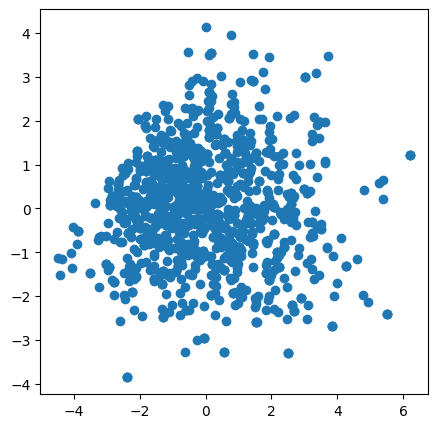

In [ ]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(5,5))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

Using the PCA transformation, it's impossible to discern distinct clusters. I'll try a UMAP transformation instead.

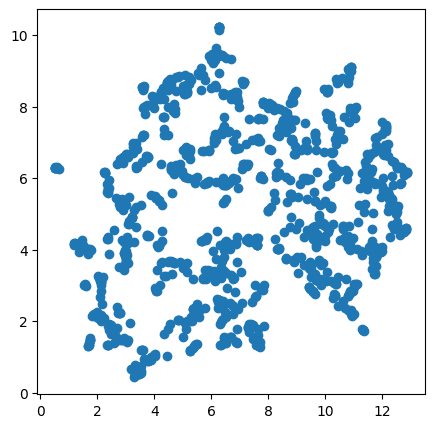

In [ ]:
umap_results = umap.UMAP(n_components=2).fit_transform(X)

plt.figure(figsize=(5,5))
plt.scatter(umap_results[:,0], umap_results[:,1])
plt.show()

The clusters might not be as distinct as would be ideal, but the UMAP transformation clearly does a better job at retaining the local similarity in the data. I'll try to tune it to see if it can be improved, starting with the metric hyperparameter.

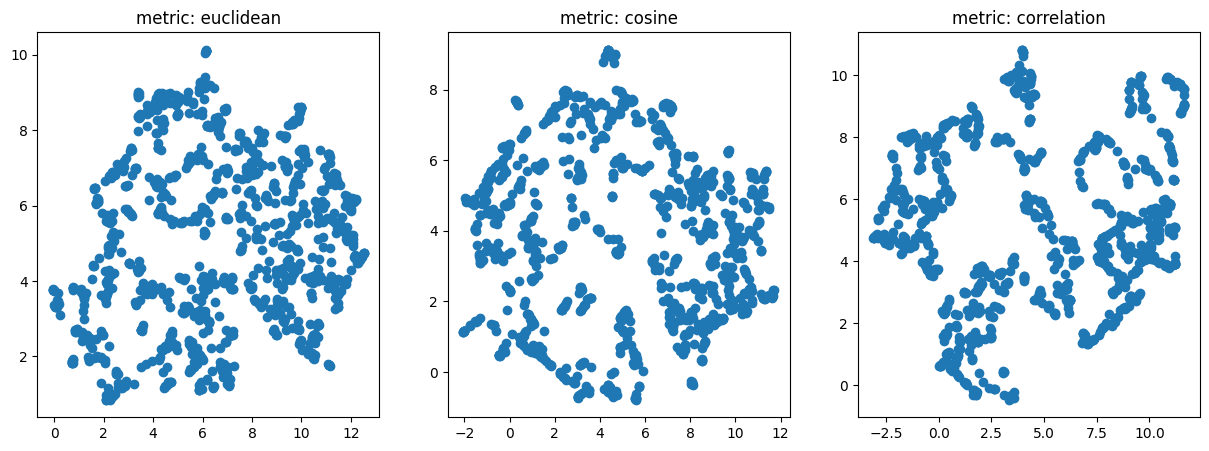

In [ ]:
x = 1
plt.figure(figsize=(15, 5))

for m in ['euclidean', 'cosine', 'correlation']:
  plt.subplot(1, 3, x)
  plt.title('metric: ' + m)
  umap_results = umap.UMAP(n_components=2, metric=m).fit_transform(X)
  plt.scatter(umap_results[:,0], umap_results[:,1])
  x += 1

plt.show()

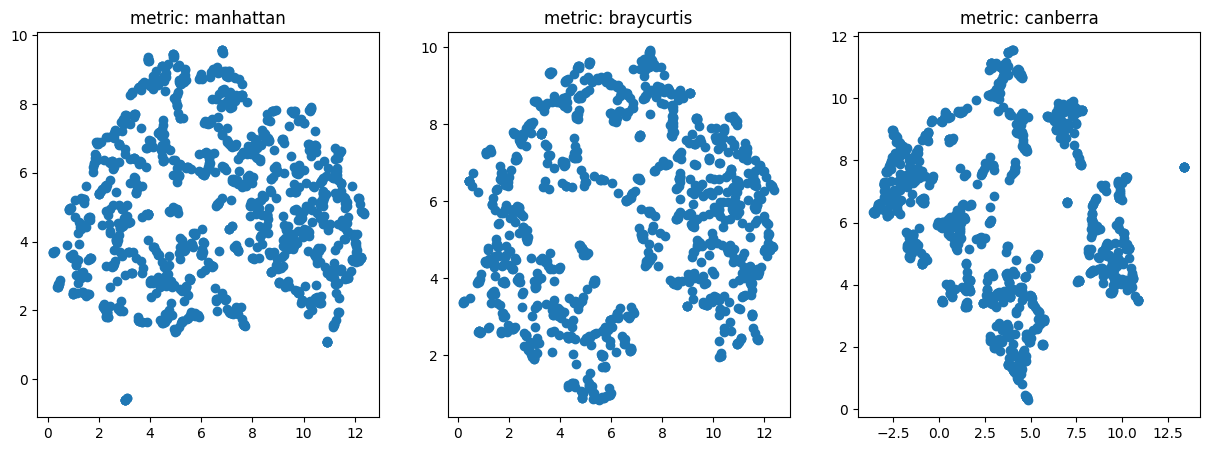

In [ ]:
x = 1
plt.figure(figsize=(15, 5))

for m in ['manhattan', 'braycurtis', 'canberra']:
  plt.subplot(1, 3, x)
  plt.title('metric: ' + m)
  umap_results = umap.UMAP(n_components=2, metric=m).fit_transform(X)
  plt.scatter(umap_results[:,0], umap_results[:,1])
  x += 1

plt.show()

Correlation looks best. Next I'll try to tune the n_neighbors hyperparameter.

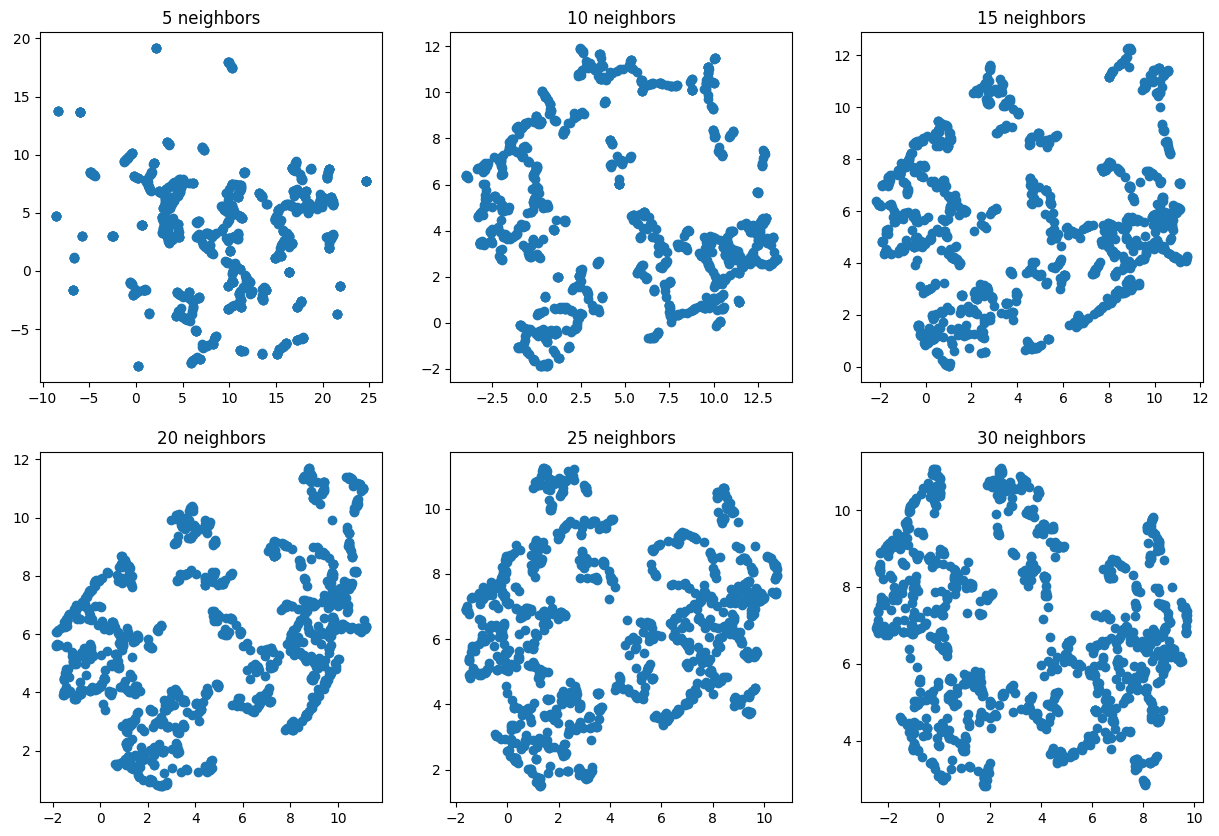

In [ ]:
x = 1
plt.figure(figsize=(15, 10))

for i in [5, 10, 15, 20, 25, 30]:
  plt.subplot(2, 3, x)
  plt.title(str(i) + ' neighbors')
  umap_results = umap.UMAP(n_components=2, n_neighbors=i, metric='correlation').fit_transform(X)
  plt.scatter(umap_results[:,0], umap_results[:,1])
  x += 1

plt.show()

The 20 neighbors model looks best. Next will be min_dist.

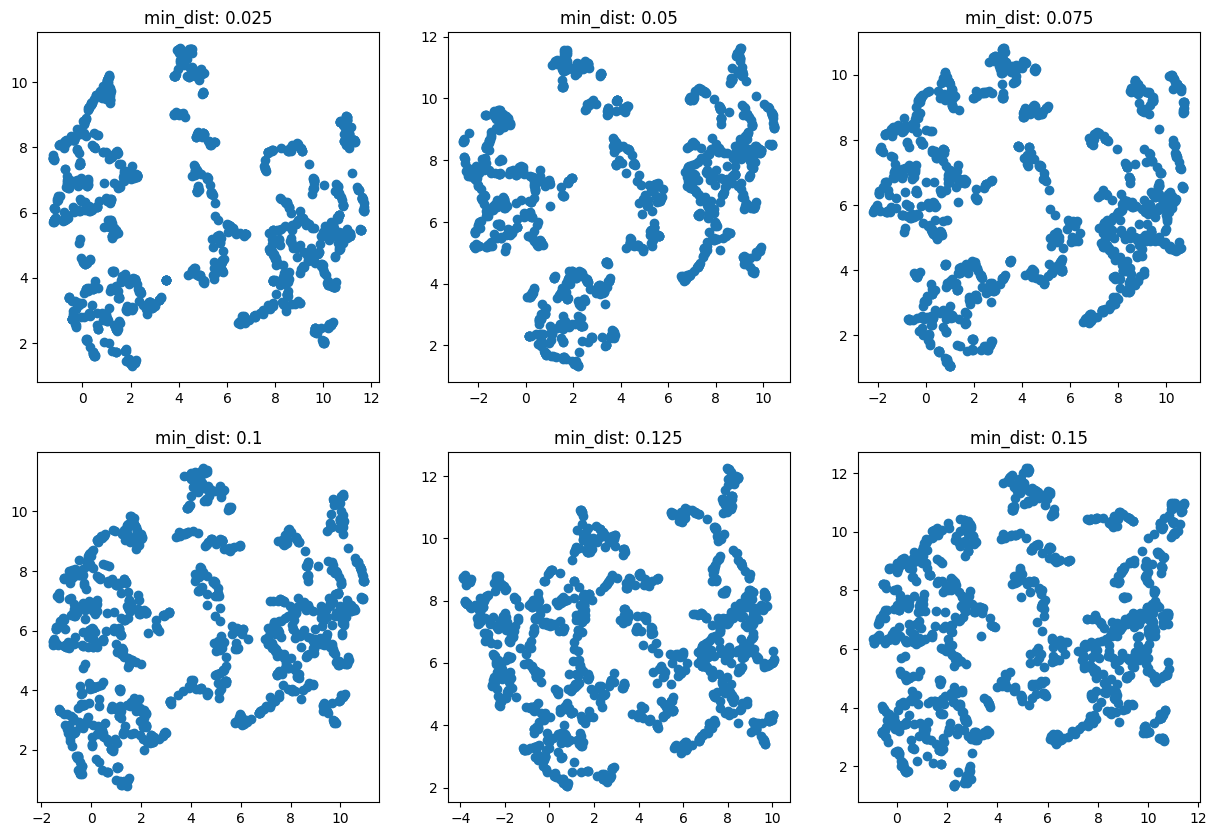

In [ ]:
x = 1
plt.figure(figsize=(15, 10))

for i in [.025, .05, .075, .1, .125, .15]:
  plt.subplot(2, 3, x)
  plt.title('min_dist: ' + str(i))
  umap_results = umap.UMAP(n_components=2, n_neighbors=20, min_dist=i, metric='correlation').fit_transform(X)
  plt.scatter(umap_results[:,0], umap_results[:,1])
  x += 1

plt.show()

The clusters are the most distinct when min_dist is equal to 0.05. Now that the UMAP transformation has been tuned, I'll try out a few basic models to see if any seem promising.

In [ ]:
umap_results = umap.UMAP(n_components=2, n_neighbors=20, min_dist=.05, metric='correlation').fit_transform(X)

# Initial Models

Now that I've cleaned and examined the data, I'll instantiate a few models with varying numbers of clusters to evaluate their performance and then tune any models that seem promising. In order to evaluate the consistency of the models, I'll divide the data into two samples and create models trained on both.

In [ ]:
X_1, X_2 = train_test_split(X, test_size=.5)
umap_1, umap_2 = train_test_split(umap_results, test_size=.5)

In [ ]:
for c in [2, 3, 4, 5, 6, 7]:
  for d in [X_1, X_2]:
    kmeans = KMeans(n_clusters=c, n_init='auto').fit_predict(d)
    print(f'K-Means silhouette with {c} clusters: {metrics.silhouette_score(d, kmeans, metric="euclidean")}')
  print('-'*50)

K-Means silhouette with 2 clusters: 0.28706916924236814
K-Means silhouette with 2 clusters: 0.3159455624776878
--------------------------------------------------
K-Means silhouette with 3 clusters: 0.2570239229162447
K-Means silhouette with 3 clusters: 0.22966713088222646
--------------------------------------------------
K-Means silhouette with 4 clusters: 0.2070525540583671
K-Means silhouette with 4 clusters: 0.2135174793290992
--------------------------------------------------
K-Means silhouette with 5 clusters: 0.2002286181636059
K-Means silhouette with 5 clusters: 0.20346158323780394
--------------------------------------------------
K-Means silhouette with 6 clusters: 0.2040705855616828
K-Means silhouette with 6 clusters: 0.1998699824880938
--------------------------------------------------
K-Means silhouette with 7 clusters: 0.19307937348338902
K-Means silhouette with 7 clusters: 0.18437620647416206
--------------------------------------------------


In [ ]:
for c in [2, 3, 4, 5, 6, 7]:
  for d in [X_1, X_2]:
    agg = AgglomerativeClustering(n_clusters=c).fit_predict(d)
    print(f'Agg silhouette with {c} clusters: {metrics.silhouette_score(d, agg, metric="euclidean")}')
  print('-'*50)

Agg silhouette with 2 clusters: 0.27140816980055127
Agg silhouette with 2 clusters: 0.29226170171087223
--------------------------------------------------
Agg silhouette with 3 clusters: 0.26312532013291284
Agg silhouette with 3 clusters: 0.2050448782076735
--------------------------------------------------
Agg silhouette with 4 clusters: 0.21613898810841015
Agg silhouette with 4 clusters: 0.1710563918691327
--------------------------------------------------
Agg silhouette with 5 clusters: 0.17370094493837754
Agg silhouette with 5 clusters: 0.15259113444493838
--------------------------------------------------
Agg silhouette with 6 clusters: 0.16151943876808486
Agg silhouette with 6 clusters: 0.14418877526879872
--------------------------------------------------
Agg silhouette with 7 clusters: 0.16029107216372793
Agg silhouette with 7 clusters: 0.14930634334718632
--------------------------------------------------


In [ ]:
for c in [2, 3, 4, 5, 6, 7]:
  for d in [X_1, X_2]:
    gmm = GaussianMixture(n_components=c).fit_predict(d)
    print(f'GMM silhouette with {c} clusters: {metrics.silhouette_score(d, gmm, metric="euclidean")}')
  print('-'*50)

GMM silhouette with 2 clusters: 0.189242341243039
GMM silhouette with 2 clusters: 0.15837504524557822
--------------------------------------------------
GMM silhouette with 3 clusters: 0.08966775589287383
GMM silhouette with 3 clusters: 0.12054799786792804
--------------------------------------------------
GMM silhouette with 4 clusters: 0.08532907173625767
GMM silhouette with 4 clusters: 0.08962876974535898
--------------------------------------------------
GMM silhouette with 5 clusters: 0.08146561710931614
GMM silhouette with 5 clusters: 0.07318776438923878
--------------------------------------------------
GMM silhouette with 6 clusters: 0.0635991402754579
GMM silhouette with 6 clusters: 0.04692853689123337
--------------------------------------------------
GMM silhouette with 7 clusters: 0.04696329311819173
GMM silhouette with 7 clusters: 0.021225297470360463
--------------------------------------------------


In [ ]:
for e in [.5, .7, .9, 1.1, 1.3, 1.5]:
  for d in [X_1, X_2]:
    dbscan = DBSCAN(eps=e).fit_predict(d)
    print(f'DBSCAN silhouette with eps = {e}: {metrics.silhouette_score(d, dbscan, metric="euclidean")}')
  print('-'*50)

DBSCAN silhouette with eps = 0.5: -0.35942191943381746
DBSCAN silhouette with eps = 0.5: -0.40001049906751246
--------------------------------------------------
DBSCAN silhouette with eps = 0.7: -0.27721442380696454
DBSCAN silhouette with eps = 0.7: -0.3031852484028599
--------------------------------------------------
DBSCAN silhouette with eps = 0.9: -0.2112373181087082
DBSCAN silhouette with eps = 0.9: -0.11900756322144421
--------------------------------------------------
DBSCAN silhouette with eps = 1.1: 0.2806308354430546
DBSCAN silhouette with eps = 1.1: 0.17520616340072753
--------------------------------------------------
DBSCAN silhouette with eps = 1.3: 0.32269312404895967
DBSCAN silhouette with eps = 1.3: 0.27470067122658864
--------------------------------------------------
DBSCAN silhouette with eps = 1.5: 0.3636816854712247
DBSCAN silhouette with eps = 1.5: 0.3659331477281846
--------------------------------------------------


The silhouette score doesn't necessarily tell the whole story, especially with clusters of irregular shape and inconsistent size like these. I'll do some visualizations of models trained on the UMAP-transformed data to get another indication of their performance.

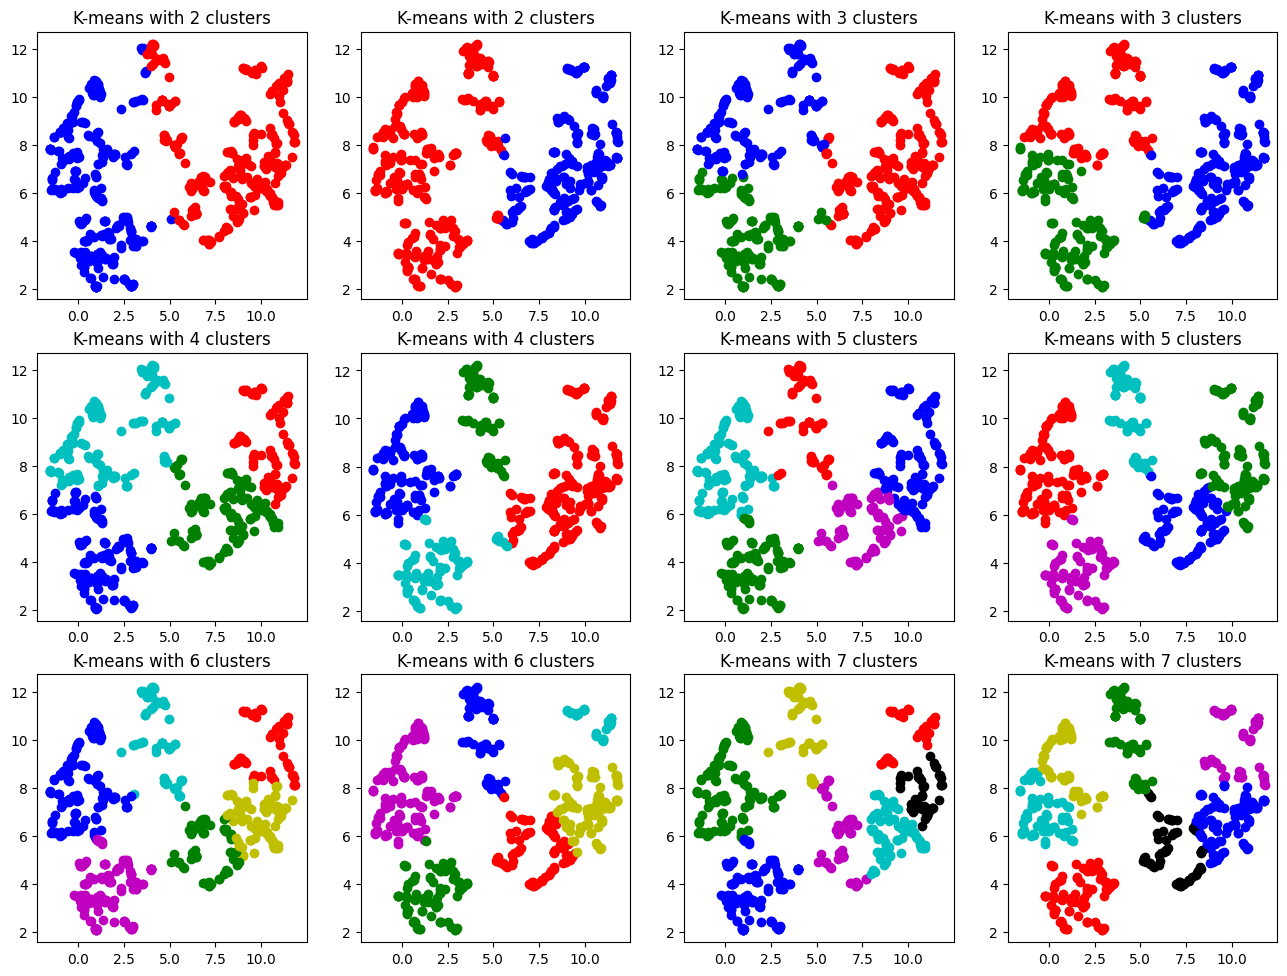

In [ ]:
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:pink', 'tab:gray', 'tab:brown', 'tab:olive']

plt.figure(figsize=(16, 16))
x = 1
for c in [2, 3, 4, 5, 6, 7]:
  for d in [umap_1, umap_2]:
    plt.subplot(4, 4, x)
    plt.title('K-means with {} clusters'.format(c))
    kmeans = KMeans(n_clusters=c, n_init='auto').fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(kmeans[i])])
    x += 1
plt.show()

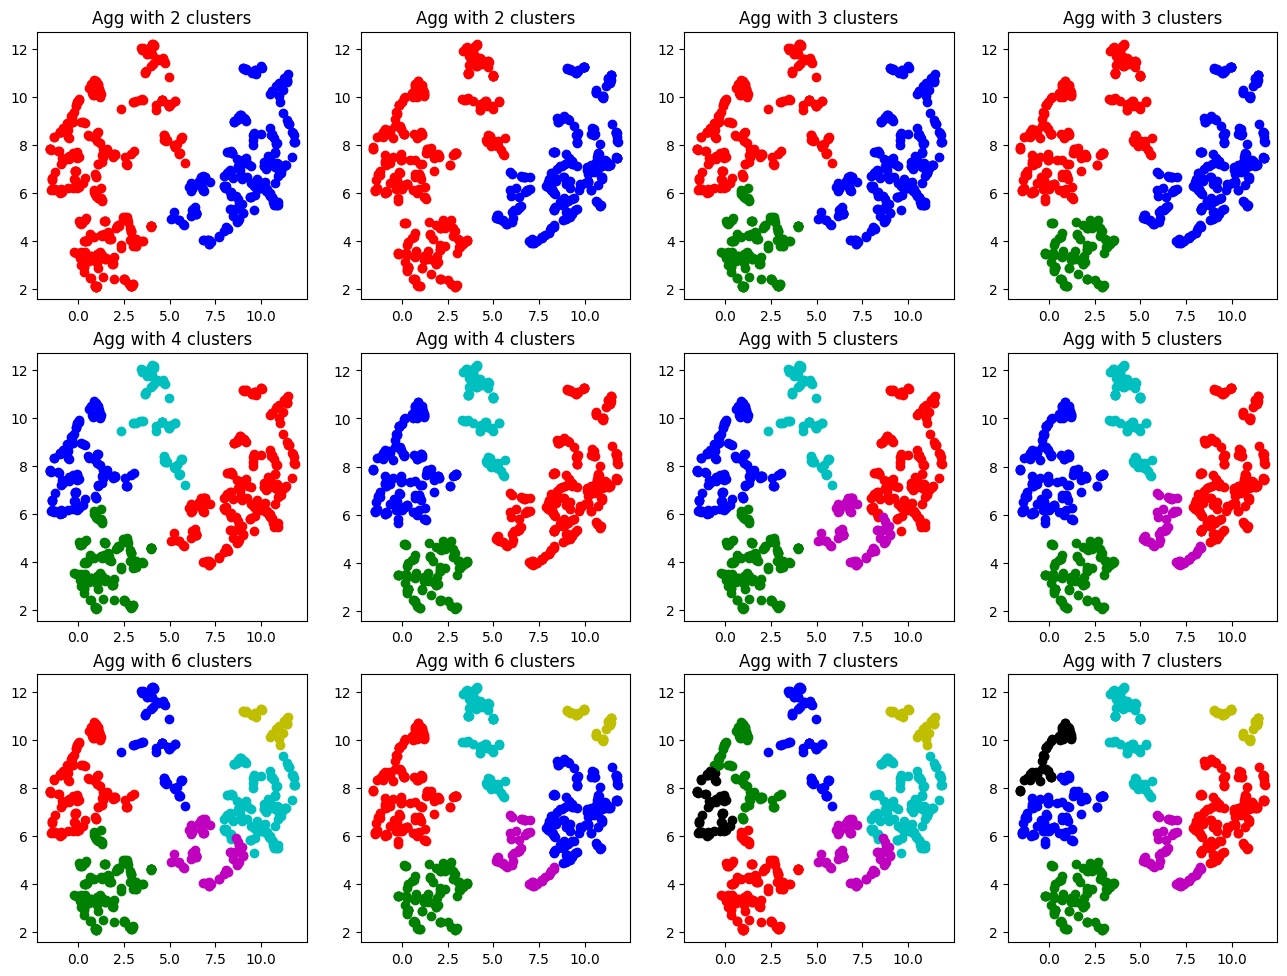

In [ ]:
plt.figure(figsize=(16, 16))
x = 1
for c in [2, 3, 4, 5, 6, 7]:
  for d in [umap_1, umap_2]:
    plt.subplot(4, 4, x)
    plt.title('Agg with {} clusters'.format(c))
    agg = AgglomerativeClustering(n_clusters=c).fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(agg[i])])
    x += 1
plt.show()

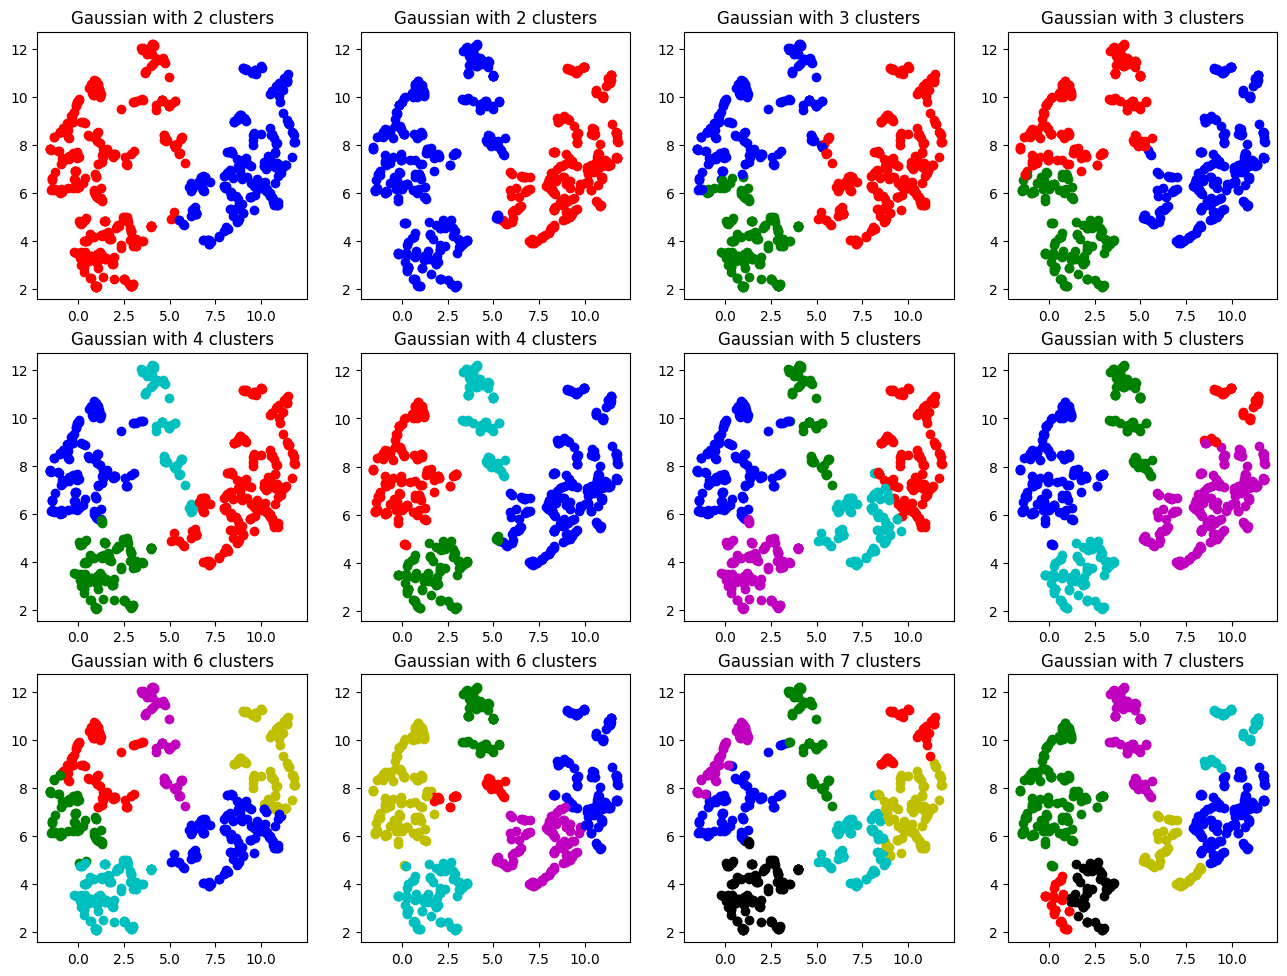

In [ ]:
plt.figure(figsize=(16, 16))
x = 1
for c in [2, 3, 4, 5, 6, 7]:
  for d in [umap_1, umap_2]:
    plt.subplot(4, 4, x)
    plt.title('Gaussian with {} clusters'.format(c))
    gmm = GaussianMixture(n_components=c).fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(gmm[i])])
    x += 1
plt.show()

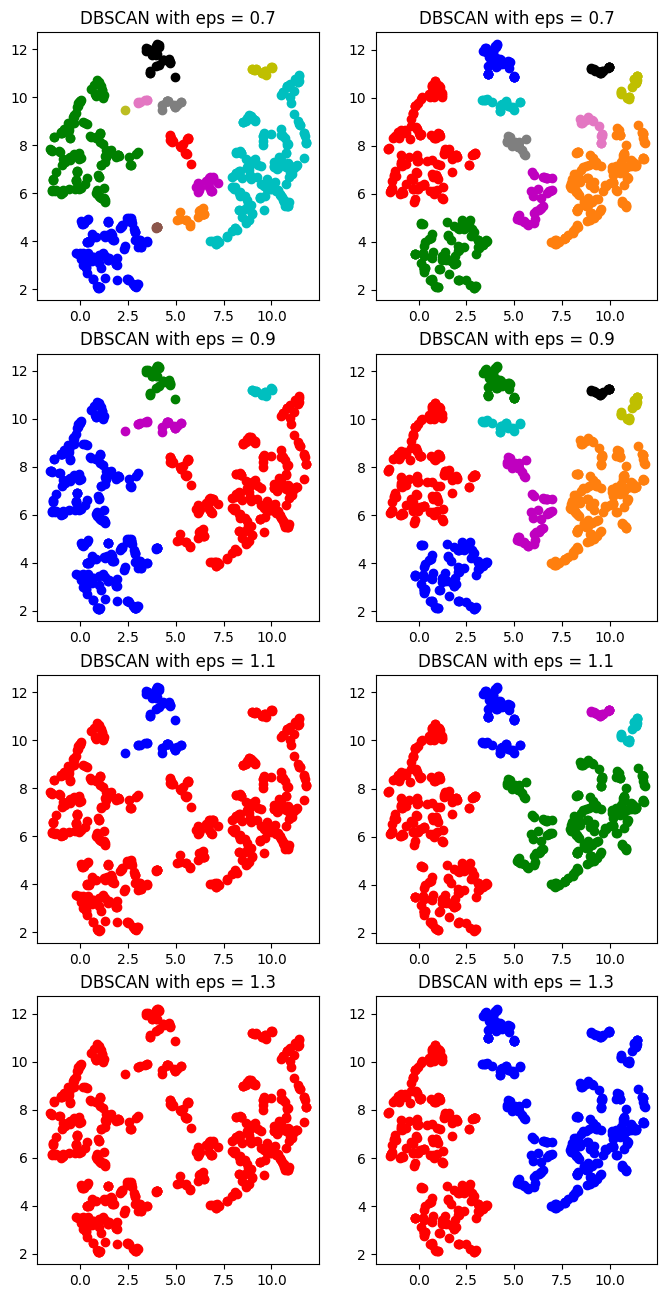

In [ ]:
plt.figure(figsize=(8, 16))
x = 1
for e in [.7, .9, 1.1, 1.3]:
  for d in [umap_1, umap_2]:
    plt.subplot(4, 2, x)
    plt.title('DBSCAN with eps = {}'.format(e))
    dbscan = DBSCAN(eps=e).fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(dbscan[i])])
    x += 1
plt.show()

The agglomerative clustering and Gaussian mixture models perform fairly well. I'll try to improve each of those.

# Agglomerative Clustering

The agglomerative clustering models looked pretty good with 4, 5, and 6 clusters. I'll tune the linkage hyperparameter while considering each of those values for n_clusters.

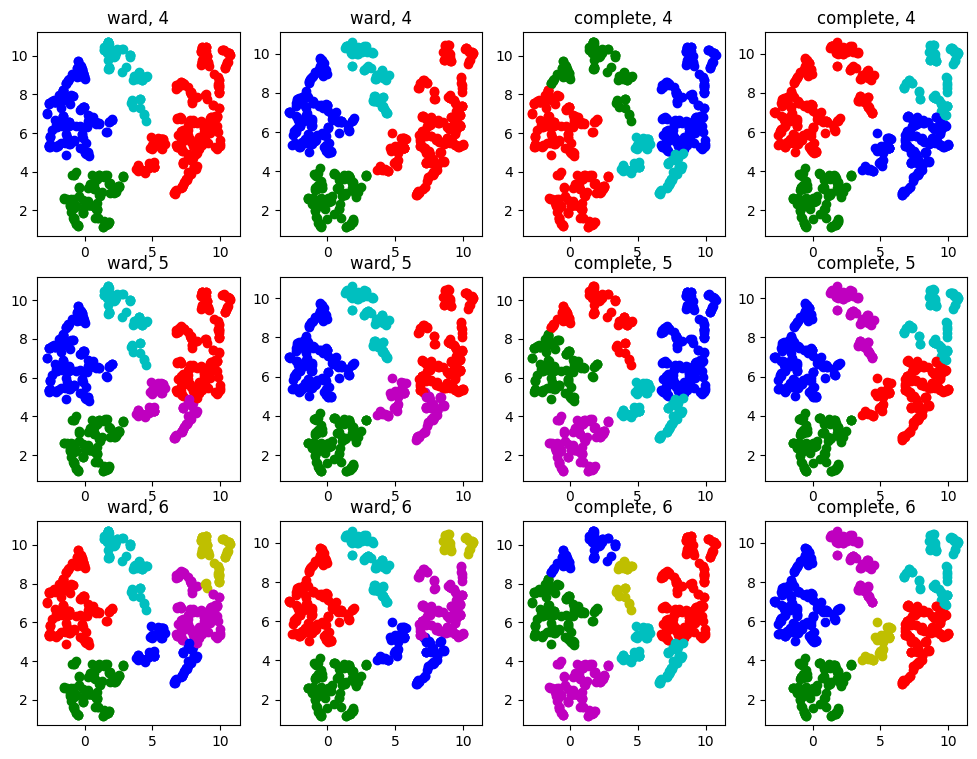

In [ ]:
plt.figure(figsize=(12, 9))
x = 1
for c in [4, 5, 6]:
  for l in ['ward', 'complete']:
    for d in [umap_1, umap_2]:
      plt.subplot(3, 4, x)
      plt.title(f'{l}, {c}')
      agg = AgglomerativeClustering(n_clusters=c, linkage=l).fit_predict(d)
      for i in range(d.shape[0]):
        plt.scatter(d[i,0], d[i,1], color=colors[int(agg[i])])
      x += 1
plt.show()

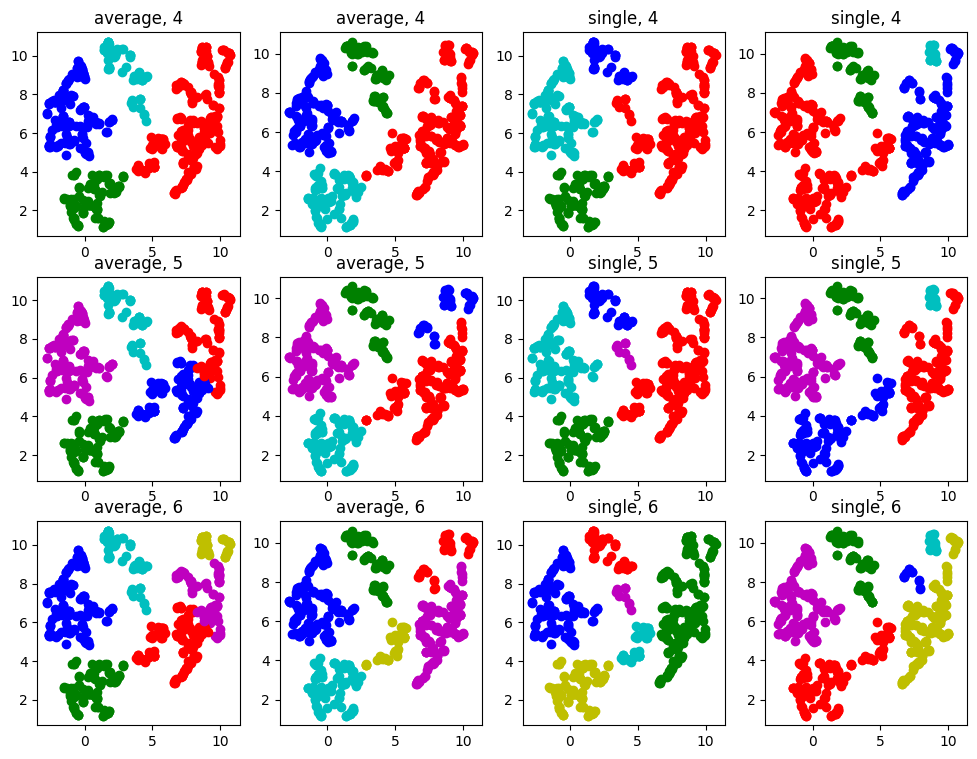

In [ ]:
plt.figure(figsize=(12, 9))
x = 1
for c in [4, 5, 6]:
  for l in ['average', 'single']:
    for d in [umap_1, umap_2]:
      plt.subplot(3, 4, x)
      plt.title(f'{l}, {c}')
      agg = AgglomerativeClustering(n_clusters=c, linkage=l).fit_predict(d)
      for i in range(d.shape[0]):
        plt.scatter(d[i,0], d[i,1], color=colors[int(agg[i])])
      x += 1
plt.show()

Ward, the default value, definitely looks like the best choice for the linkage hyperparameter and the model with 4 clusters looks better than the 5 and 6 cluster models. There aren't many hyperparameters to tune with an agglomerative clustering model. Ward being the best value for linkage simplifies the tuning process further, since the only option for metric compatible with ward is Euclidean distance. Next I'll try to optimize the Gaussian mixture model.

# Gaussian Mixture Model

There were some awkward-looking cluster assignments in the 5 and 6 cluster Gaussian mixture models that I created earlier. Another discouraging sign was the inconsistency of the clusters across the subsamples. I'll focus on the 4 cluster model, as that was easily the most promising and comparable in quality to the agglomerative clustering model. The first hyperparameter I'll address is the type of the covariance matrix.

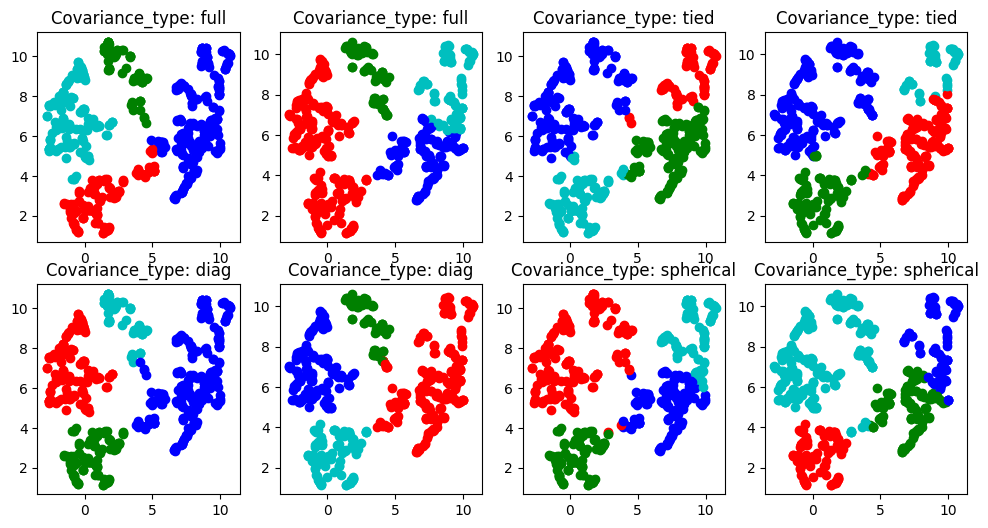

In [ ]:
plt.figure(figsize=(12, 6))
x = 1
for c in ['full', 'tied', 'diag', 'spherical']:  
  for d in [umap_1, umap_2]:
    plt.subplot(2, 4, x)
    plt.title('Covariance_type: {}'.format(c))
    gmm = GaussianMixture(n_components=4, covariance_type=c).fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(gmm[i])])
    x += 1
plt.show()

There are a few unusually allocated points but overall, the diagonal covariance matrix is preferable. Next will be n_init.

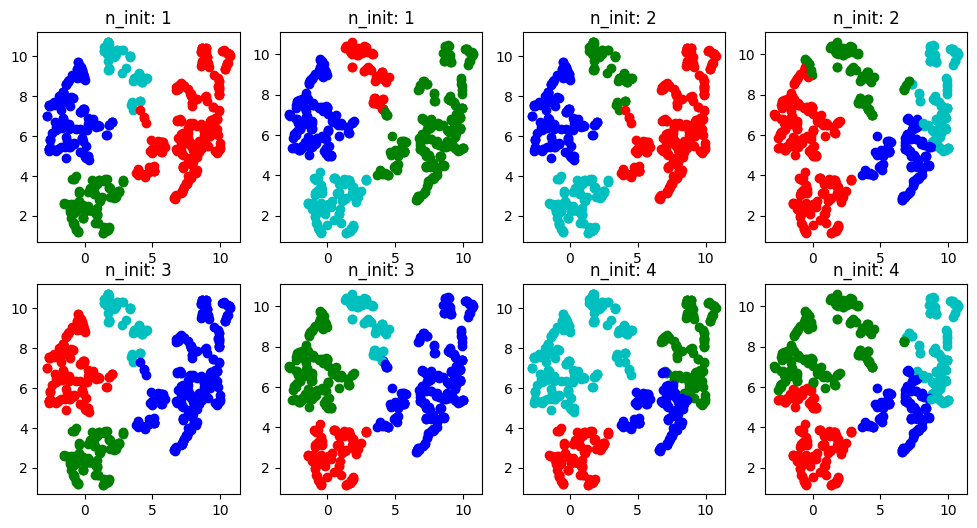

In [ ]:
plt.figure(figsize=(12, 6))
x = 1
for n in [1, 2, 3, 4]:  
  for d in [umap_1, umap_2]:
    plt.subplot(2, 4, x)
    plt.title('n_init: {}'.format(n))
    gmm = GaussianMixture(n_components=4, covariance_type='diag').fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(gmm[i])])
    x += 1
plt.show()

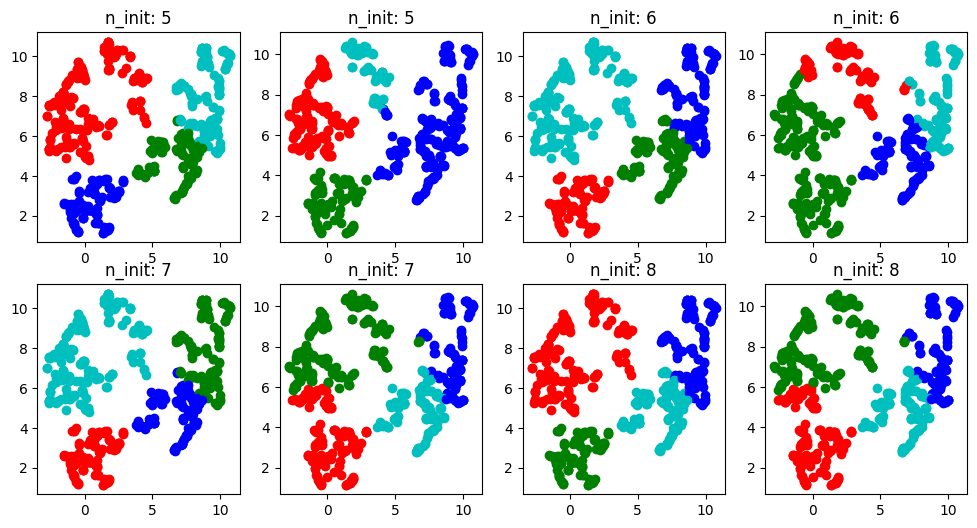

In [ ]:
plt.figure(figsize=(12, 6))
x = 1
for n in [5, 6, 7, 8]:  
  for d in [umap_1, umap_2]:
    plt.subplot(2, 4, x)
    plt.title('n_init: {}'.format(n))
    gmm = GaussianMixture(n_components=4, covariance_type='diag').fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(gmm[i])])
    x += 1
plt.show()

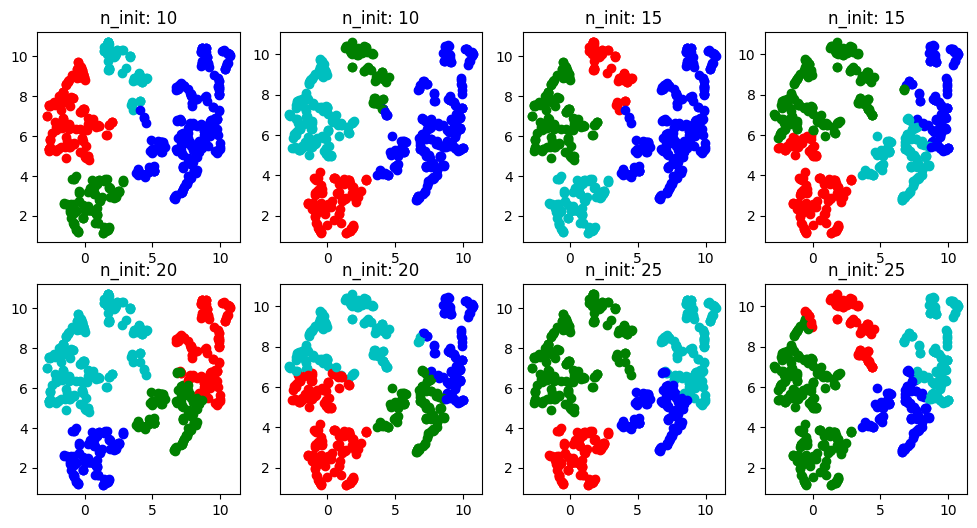

In [ ]:
plt.figure(figsize=(12, 6))
x = 1
for n in [10, 15, 20, 25]:  
  for d in [umap_1, umap_2]:
    plt.subplot(2, 4, x)
    plt.title('n_init: {}'.format(n))
    gmm = GaussianMixture(n_components=4, covariance_type='diag').fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(gmm[i])])
    x += 1
plt.show()

The results change quite a bit from one model to the next. This isn't a positive sign for the performance of the model but I'll try to tune the max_iter hyperparameter next and see if that improves the model's performance. I'll proceed with a value of 3 for n_init.

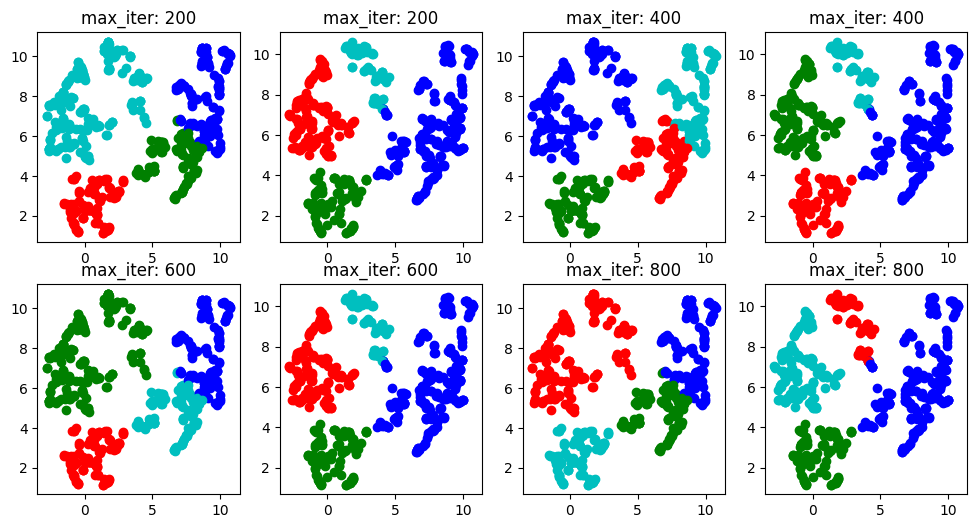

In [ ]:
plt.figure(figsize=(12, 6))
x = 1
for m in [200, 400, 600, 800]:  
  for d in [umap_1, umap_2]:
    plt.subplot(2, 4, x)
    plt.title('max_iter: {}'.format(m))
    gmm = GaussianMixture(n_components=4, max_iter=m, n_init=3, covariance_type='diag').fit_predict(d)
    for i in range(d.shape[0]):
      plt.scatter(d[i,0], d[i,1], color=colors[int(gmm[i])])
    x += 1
plt.show()

The models are still inconsistent across subsamples and values of various hyperparameters.

# Conclusions

It's clear that the agglomerative clustering model does a better and more consistent job of clustering the data. The Gaussian mixture model produced different clusters from one instantiation to the next and the quality of those clusters -- as could be discerned through the 2-dimensional UMAP transformation of the data -- was inferior to that of the clusters created by the agglomerative clustering model. I'll show one last scatterplot of the final agglomerative clustering model trained on the full UMAP-transformed data (from before the division into two samples) and print out the silhouette coefficient of the model trained on the whole dataset.

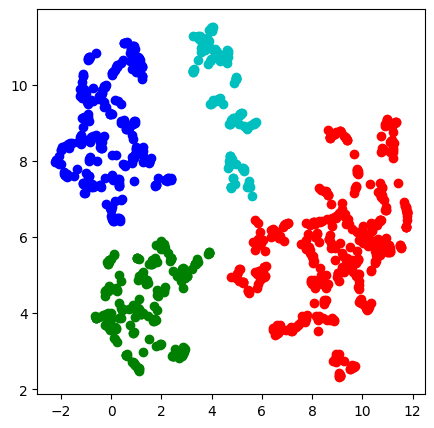

In [ ]:
plt.figure(figsize=(5,5))
agg = AgglomerativeClustering(n_clusters=4).fit_predict(umap_results)
for i in range(umap_results.shape[0]):
  plt.scatter(umap_results[i,0], umap_results[i,1], color=colors[int(agg[i])])
plt.show()

In [ ]:
agg = AgglomerativeClustering(n_clusters=4).fit_predict(X)
print(f'Silhouette coefficient of model on full dataset: {metrics.silhouette_score(X, agg, metric="euclidean")}')

Silhouette coefficient of model on full dataset: 0.15265328298238742


The silhouette coefficient may not be very high but the irregular shapes and different sizes of the clusters don't lend themselves well to a high value. The scatterplot makes it clear that the model does a good job of allocating the data points to the appropriate clusters.

The objective in creating this model was to learn about the differences in the data of applicants that could affect their eligibility for a loan. With that in mind, I'll see what information I can glean about the original variables with regard to each cluster.

In [ ]:
for i in range(4):
    indices = np.where(agg == i)[0]
    subset = raw_df.iloc[indices]
    averages = subset.mean()
    
    for name, mean in zip(raw_df.columns[:6], averages):
      print(f'Cluster {i}: {name}: {mean}')
    print('-'*50)

Cluster 0: age: 40.38701298701299
Cluster 0: employ: 15.057142857142857
Cluster 0: income: 78.21558441558442
Cluster 0: debtinc: 9.077142857142857
Cluster 0: creddebt: 2.295014755844156
Cluster 0: othdebt: 4.284322906493507
--------------------------------------------------
Cluster 1: age: 30.341232227488153
Cluster 1: employ: 5.398104265402844
Cluster 1: income: 27.933649289099527
Cluster 1: debtinc: 4.313744075829384
Cluster 1: creddebt: 0.29912828436018957
Cluster 1: othdebt: 0.6544309573459716
--------------------------------------------------
Cluster 2: age: 36.040462427745666
Cluster 2: employ: 7.69364161849711
Cluster 2: income: 47.202312138728324
Cluster 2: debtinc: 20.863583815028903
Cluster 2: creddebt: 3.387501358381502
Cluster 2: othdebt: 6.59488014450867
--------------------------------------------------
Cluster 3: age: 32.3753280839895
Cluster 3: employ: 4.808398950131234
Cluster 3: income: 28.88976377952756
Cluster 3: debtinc: 9.34015748031496
Cluster 3: creddebt: 0.8218

There are noticeable differences between these clusters. Members of cluster 0 are -- on average -- 10 years older than members of cluster 1. They also have an average of 10 years more work experience (predictably) and earn far more money than all of the other clusters. It's easy to see how a clustering model like this could be useful to a bank. It does a good job of neatly grouping people based on important indicators of financial stability.